# Oxygen Analysis Module

In [4]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

## Load the relevent packages
#library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 0

In [18]:
O2sol = function(S, T) {
    # convert T to scaled temperature
    temp_S = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871
    A1_o2 = 3.20291
    A2_o2 = 4.17887
    A3_o2 = 5.10006
    A4_o2 = -9.86643e-2
    A5_o2 = 3.80369
    B0_o2 = -7.01577e-3
    B1_o2 = -7.70028e-3
    B2_o2 = -1.13864e-2
    B3_o2 = -9.51519e-3
    C0_o2 = -2.75915e-7

    # Corrected Eqn (8) of Garcia and Gordon 1992 (umol / kg)
    exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S^2 + A3_o2*temp_S^3 + A4_o2*temp_S^4 + A5_o2*temp_S^5 + 
        S*(B0_o2 + B1_o2*temp_S +B2_o2*temp_S^2 + B3_o2*temp_S^3) + C0_o2*S^2)
}

## Load the ship data

In [2]:
load('RStates/ship.final.rdata')

## Load the Winkler data

In [7]:
winkler = read.xlsx('Raw Data/CTD/Winkler O2 data CCE cruise.xlsx')
str(winkler)

'data.frame':	27 obs. of  15 variables:
 $ X1         : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Bottle#    : num  1309 1841 1703 693 1840 ...
 $ temp       : num  13.6 14.3 14.4 14.4 13.4 13.4 13.3 13.3 13.7 13.7 ...
 $ ml/l       : num  6.22 5.9 7.65 7.67 6.45 ...
 $ date       : num  42891 42892 43625 43625 42899 ...
 $ time       : chr  NA "0.49305555555555558" NA NA ...
 $ station    : chr  "underway" "underway" "underway" "underway" ...
 $ long       : chr  "36.08.5637N" "34.50.66N" "35.03.529" "35.03.529" ...
 $ lat        : chr  "123.08.1362W" "122.19.3871W" "121.07.1770W" "121.07.1770W" ...
 $ O2.EIMS.%  : num  102 101 140 140 111 ...
 $ temp.EIMS  : chr  NA NA NA NA ...
 $ O2.MIMS    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ O2conc.MIMS: num  NA NA NA NA NA NA NA NA NA NA ...
 $ temp.MIMS  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ otes       : chr  "from main lab water supply" "from main lab water supply" "from main lab water supply" "from hydro lab flowthrough" ...


In [8]:
head(winkler)

X1,Bottle#,temp,ml/l,date,time,station,long,lat,O2.EIMS.%,temp.EIMS,O2.MIMS,O2conc.MIMS,temp.MIMS,otes
1,1309,13.6,6.224,42891,NA,underway,36.08.5637N,123.08.1362W,102.00,NA,NA,NA,NA,from main lab water supply
2,1841,14.3,5.897,42892,0.49305555555555558,underway,34.50.66N,122.19.3871W,100.90,NA,NA,NA,NA,from main lab water supply
3,1703,14.4,7.650,43625,NA,underway,35.03.529,121.07.1770W,140.00,NA,NA,NA,NA,from main lab water supply
4,693,14.4,7.666,43625,NA,underway,35.03.529,121.07.1770W,140.00,NA,NA,NA,NA,from hydro lab flowthrough
5,1840,13.4,6.446,42899,0.39583333333333337,underway,34.43.9803N,121.42.4288W,110.73,NA,NA,NA,NA,from hydro lab flowthrough
6,1797,13.4,6.458,42899,0.39583333333333337,underway,34.43.9803N,121.42.4288W,110.62,NA,NA,NA,NA,bubbles in MgCl/water from hydrolab


In [10]:
winkler$time = conv_excel_time(as.numeric(winkler$time) + as.numeric(winkler$date))

Warning message in as.Date(x, origin = "1899-12-30", tz = tz):
“NAs introduced by coercion”

In [11]:
nrow(winkler)
winkler = winkler[!is.na(winkler$time),]
nrow(winkler)

[1] 27

[1] 19

In [23]:
summary(O2sol(ship.data$SA, ship.data$TT))/32

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
7.090625 7.709375 7.909375 7.868750 8.106250 8.584375 

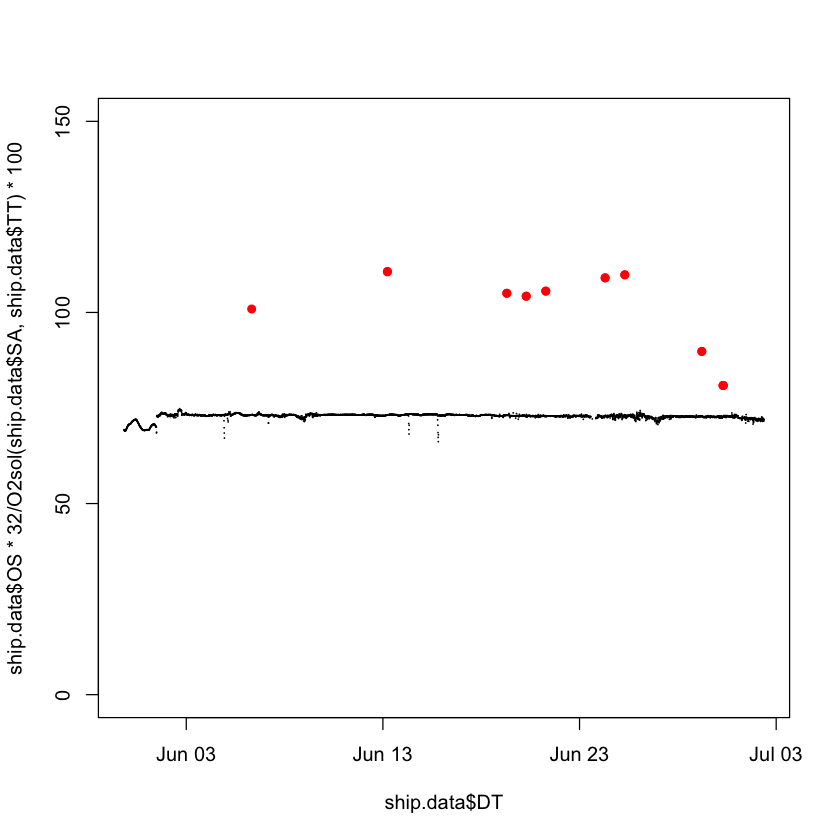

In [25]:
plot(ship.data$DT, ship.data$OS * 32 / O2sol(ship.data$SA, ship.data$TT) * 100, pch=16, cex=0.2, ylim=c(0,150)) # mmol / L
points(winkler$time, winkler$'O2.EIMS.%', col='red', pch=16)